In [20]:
import pandas as pd, numpy as np
from vivarium import Artifact

from pathlib import Path

from math import floor

import matplotlib.pyplot as plt

import pdb

pd.options.mode.chained_assignment = None  # default='warn'

In [21]:
FORECASTED_POP_KEY = "population.structure"
SCALING_FACTOR_KEY = "population.scaling_factor"
ACMR_KEY = "cause.all_causes.cause_specific_mortality_rate"
CSMR_KEY = "cause.alzheimers_disease_and_other_dementias.cause_specific_mortality_rate"
BBBM_INCIDENCE_KEY = "cause.alzheimers.susceptible_to_bbbm_transition_count"
TIME_STEP_YEARS = 1
GBD_AGE_GROUP_YEARS = 5
TIME_STEPS_PER_AGE_GROUP = GBD_AGE_GROUP_YEARS / TIME_STEP_YEARS

SIM_START = 2023
SIM_END = 2100

location = "United States of America"
artifacts_dir = (
    "/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/artifacts/model7.0"
)

BBBM_TESTING_RATES = [
    (2030, 0.1),
    (2035, 0.2),
    (2040, 0.4),
    (2045, 0.6),
    (SIM_END, 0.6),
]

VARIABLE_TREATMENT_INITIATION_RATES = [
    (2030, 0.4),
    (2035, 0.7),
    (SIM_END, 0.7),
]

US_TREATMENT_INITIATION_RATES = [
    (2030, 0.8),
    (SIM_END, 0.8),
]

JAPAN_TREATMENT_INITIATION_RATES = [
    (2030, 0.3),
    (SIM_END, 0.3),
]

TREATMENT_INITIATION_RATES_LOOKUP = {
    "United States of America": US_TREATMENT_INITIATION_RATES,
    "Japan": JAPAN_TREATMENT_INITIATION_RATES,
}

NON_AGE_OBSERVERS = [
    "deaths",
    "exits_to_sim",
    "incidence",
    "age_outs",
    "to_test",
    "new_tests",
    "new_pos_tests",
    "incident_tests",
    "over_thresh",
    "neg_0ya",
    "neg_1ya",
    "neg_2ya",
    "pos",
    "treatment_initiated",
    "treatment_not_initiated",
    "treatment_completed",
    "treatment_discontinued",
]

In [39]:
def get_bbbm_testing_rate(year):
    years = [year for year, _ in BBBM_TESTING_RATES]
    rates = [rate for _, rate in BBBM_TESTING_RATES]
    if year < years[0]:
        # 0.0 before first year with defined rate
        return 0.0
    elif year > years[-1]:
        return years[-1]
    else:
        return np.interp(year, years, rates)

In [40]:
def get_treatment_inititaion_rate(year):
    LOC_SPECIFIC_RATES = TREATMENT_INITIATION_RATES_LOOKUP.get(
        location, VARIABLE_TREATMENT_INITIATION_RATES
    )
    years = [year for year, _ in LOC_SPECIFIC_RATES]
    rates = [rate for _, rate in LOC_SPECIFIC_RATES]
    if year < years[0]:
        return 0.0
    elif year > years[-1]:
        return 0.0
    else:
        return np.interp(year, years, rates)

In [24]:
def load_artifact(location, artifacts_dir):
    art_filename = f"{location.lower().replace(' ', '_')}.hdf"
    return Artifact(Path(artifacts_dir) / art_filename)

In [25]:
def initialize_pop_table(location, artifacts_dir) -> pd.DataFrame:
    art = load_artifact(location, artifacts_dir)
    forecasted_pop = (
        art.load(FORECASTED_POP_KEY)
        .query("year_start == 2021 & age_start >=60 & age_start<80")
        .mean(axis=1)
        .droplevel(["location", "year_start", "year_end"])
    )
    all_states_prev = (
        art.load(SCALING_FACTOR_KEY)
        .query("age_start >=60 & age_start<80")  # only 2023 data
        .mean(axis=1)
        .droplevel(["year_start", "year_end"])
    )
    groups = forecasted_pop * (1 - all_states_prev)
    # build table with rows where age_end - age_start = time step (1 year)
    table = pd.DataFrame(
        index=pd.MultiIndex.from_tuples([], names=list(groups.index.names)),
        columns=["over_thresh", "neg_0ya", "neg_1ya", "neg_2ya", "pos", "to_test"],
    )
    for index, value in groups.items():
        (sex, age_start, age_end) = index
        while age_start < age_end:
            table.loc[(sex, age_start, age_start + 1)] = {
                "over_thresh": value / TIME_STEPS_PER_AGE_GROUP,
                # 0% annual testing rate at sim start
                "neg_0ya": 0,
                "neg_1ya": 0,
                "neg_2ya": 0,
                "pos": 0,
                "to_test": 0,  # placeholder for on time step calculations - this should always be 0 once the table is updated
            }

            age_start += 1
    return table

In [26]:
def get_prev_table_index(cur_index):
    (sex, age_start, age_end) = cur_index
    return (sex, age_start - TIME_STEP_YEARS, age_end - TIME_STEP_YEARS)

In [27]:
def increase_person_time_keys(person_time, keys: dict):
    for key, amount in keys.items():
        person_time[key] += amount


def move_people(row, from_col: str, to_col: str, count):
    row[from_col] -= count
    row[to_col] += count


def run_time_step(pop_table, year, new_entrants, bbbm_incidence, mortality):
    person_time = dict({"year": year})
    for observer_key in NON_AGE_OBSERVERS:
        person_time[observer_key] = 0

    for index, row in pop_table.iloc[::-1].iterrows():  # iterate ages in reverse order
        (sex, age_start, _) = index
        prev_index = get_prev_table_index(index)
        lookup_year = min(year, 2050)

        test_rate = get_bbbm_testing_rate(year)

        # 60 YEAR OLDS
        if age_start == 60:
            row[:] = 0  # clear previous years populatoin
            total_incident_60_yos = (
                new_entrants.loc[(sex, lookup_year)] / GBD_AGE_GROUP_YEARS
            )

            # test X% of new 60 yos (will move to "neg 0 y ago" or "positive")
            row.to_test = total_incident_60_yos * test_rate
            # other new 60 yos do not meet propensity threshold
            row.over_thresh = total_incident_60_yos * (1 - test_rate)

            increase_person_time_keys(
                person_time,
                {
                    "incidence": total_incident_60_yos,
                    "incident_tests": total_incident_60_yos * test_rate,
                },
            )
        # OTHER AGES
        else:
            if age_start == 79:  # record people aging out of table
                increase_person_time_keys(
                    person_time, {"age_outs": sum(pop_table.loc[index])}
                )

            # move people into new age groups:
            row = pop_table.loc[prev_index]  # previous age group

            # MORTALITY
            age_group_start = (
                floor((age_start - 1) / GBD_AGE_GROUP_YEARS) * GBD_AGE_GROUP_YEARS
            )  # previous age_start, rounded to GBD age group boundaries

            index_in_groups = (
                sex,
                age_group_start,
                age_group_start + 5,
                lookup_year,
                lookup_year + 1,
            )
            mortality_rate = mortality.loc[index_in_groups]
            increase_person_time_keys(
                person_time, {"deaths": row.over_thresh * mortality_rate}
            )
            row.over_thresh *= 1 - mortality_rate

            # REMOVE THOSE ENTERING SIM (incident to pre-clinical):
            exits_to_sim = bbbm_incidence.loc[index_in_groups] / GBD_AGE_GROUP_YEARS
            row.over_thresh -= exits_to_sim
            increase_person_time_keys(person_time, {"exits_to_sim": exits_to_sim})

            # UPDATE STATES
            delta = test_rate - get_bbbm_testing_rate(year - 1)
            total_age_pop = sum(row)
            # Note: The total age pop denominator we use is important, as well as whether it
            #       includes people who have tested positive.
            # For now, I'm keeping people who test positive in the sim so that they are included
            # in this denominator with the goal of matching "% ever eligible tested" metric
            move_people(row, "over_thresh", "to_test", delta * total_age_pop)
            move_people(row, "neg_2ya", "to_test", row.neg_2ya)
            move_people(row, "neg_1ya", "neg_2ya", row.neg_1ya)
            move_people(row, "neg_0ya", "neg_1ya", row.neg_0ya)

        # if index[0] == "Female" and ((age_start - 60) % 3 == 0):
        #    print(f"{year}, {age_start}: {row.to_test} / {row.sum()}")

        # record number of tests and positive tests
        pos_tests = row.to_test * 0.1  # 10% of tests are false positive
        increase_person_time_keys(person_time, {"new_tests": row.to_test})
        increase_person_time_keys(person_time, {"new_pos_tests": pos_tests})

        # TEST
        move_people(row, "to_test", "pos", pos_tests)
        # remainder are true negative
        move_people(row, "to_test", "neg_0ya", row.to_test)
        # now to_test should be back to zero

        # TREATMENT
        treatment_initiation_rate = get_treatment_inititaion_rate(year)
        initiations = pos_tests * treatment_initiation_rate
        non_initiations = pos_tests * (1 - treatment_initiation_rate)
        treatment_completions = initiations * 0.9
        treatment_discontinuations = initiations * 0.1

        # UPDATE COLUMN AND TREATMENT OBSERVERS
        increase_person_time_keys(
            person_time,
            {
                "over_thresh": row.over_thresh,
                "neg_0ya": row.neg_0ya,
                "neg_1ya": row.neg_1ya,
                "neg_2ya": row.neg_2ya,
                "pos": row.pos,
                "treatment_initiated": initiations,
                "treatment_not_initiated": non_initiations,
                "treatment_completed": treatment_completions,
                "treatment_discontinued": treatment_discontinuations,
            },
        )

        person_time[age_start] = person_time.get(age_start, 0) + row.sum()
        pop_table.loc[index] = row

    return person_time

In [28]:
def load_background_mortality():
    # copied from loader.py
    art = load_artifact(location, artifacts_dir)
    acmr = art.load(ACMR_KEY)
    csmr = art.load(CSMR_KEY).droplevel(["year_start", "year_end"])

    # for now, assume csmr is the same for all years based on docs
    csmr_all_years = pd.DataFrame(csmr, index=acmr.index)
    return (
        (acmr - csmr_all_years).query("age_start >= 60 & age_start < 80").mean(axis=1)
    )

In [29]:
# calculate 60 to 61 year olds who are not in simulation for each forecast year
art = load_artifact(location, artifacts_dir)
new_entrants_forecasted = (
    art.load(FORECASTED_POP_KEY)
    .query("age_start == 60")
    .mean(axis=1)
    .droplevel(["location", "age_start", "age_end", "year_end"])
)
new_entrants_all_states_prev = (
    art.load(SCALING_FACTOR_KEY)
    .query("age_start == 60")  # only 2023 data
    .mean(axis=1)
    .droplevel(["age_start", "age_end", "year_start", "year_end"])
)
new_entrants = new_entrants_forecasted * (1 - new_entrants_all_states_prev)

background_mortality = load_background_mortality()

bbbm_incidence_counts = (
    art.load(BBBM_INCIDENCE_KEY).query("age_start >= 60 & age_start < 80").mean(axis=1)
)

In [41]:
# population table of people in location ages 60-80 who do not have pre-clinical, MCI or AD
pop_table = initialize_pop_table(location, artifacts_dir)

# person-time observer
person_time = []

for year in range(SIM_START, SIM_END):
    year_person_time = run_time_step(
        pop_table, year, new_entrants, bbbm_incidence_counts, background_mortality
    )
    person_time.append(year_person_time)

/tmp/ipykernel_244066/2381479959.py:125: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '89160.85513346622' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  pop_table.loc[index] = row
/tmp/ipykernel_244066/2381479959.py:125: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '9906.761681496248' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  pop_table.loc[index] = row
/tmp/ipykernel_244066/2381479959.py:125: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '90737.81628800633' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  pop_table.loc[index] = row
/tmp/ipykernel_244066/2381479959.py:125: FutureWarning: Setting an item of incompatib

In [55]:
age_groups = pd.DataFrame(person_time).drop(NON_AGE_OBSERVERS, axis=1).set_index("year")
age_groups = age_groups[age_groups.columns[::-1]]  # reverse order
non_age_observers = pd.DataFrame(person_time)[NON_AGE_OBSERVERS + ["year"]].set_index(
    "year"
)
pop_components = non_age_observers[["deaths", "exits_to_sim", "incidence", "age_outs"]]
pop_components["total_out"] = pop_components[
    ["deaths", "exits_to_sim", "age_outs"]
].sum(axis=1)

columns = non_age_observers[["over_thresh", "neg_0ya", "neg_1ya", "neg_2ya", "pos"]]
tests = non_age_observers[["to_test", "new_tests", "new_pos_tests", "incident_tests"]]
treatment = non_age_observers[
    [
        "treatment_initiated",
        "treatment_not_initiated",
        "treatment_completed",
        "treatment_discontinued",
        "new_pos_tests",
    ]
]

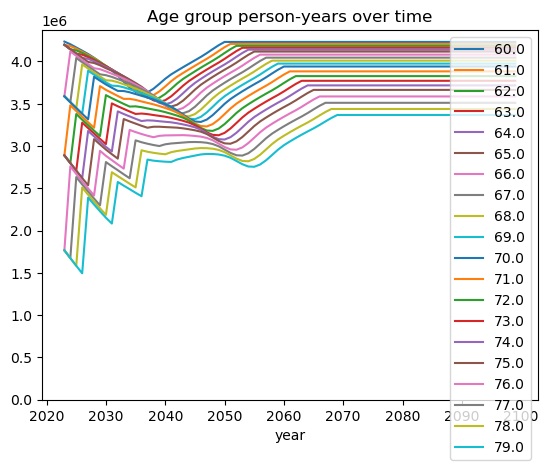

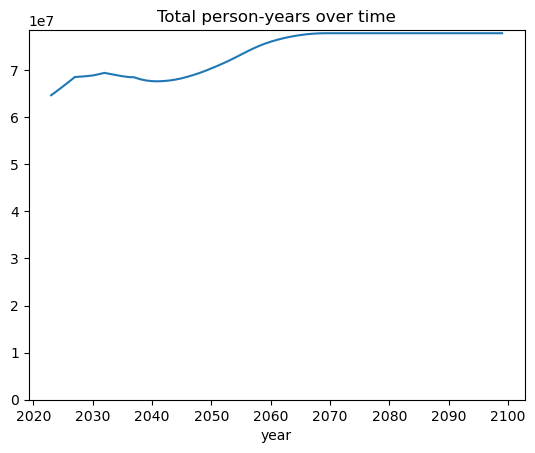

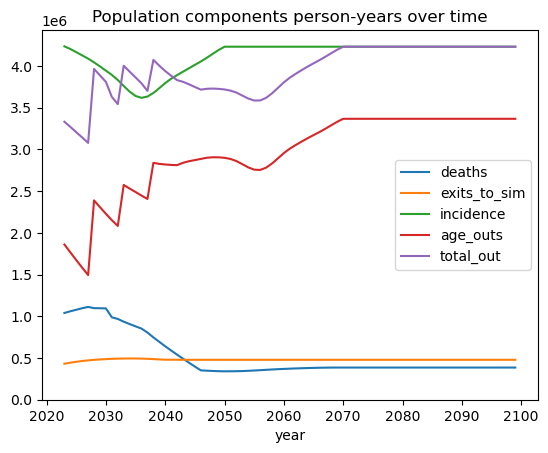

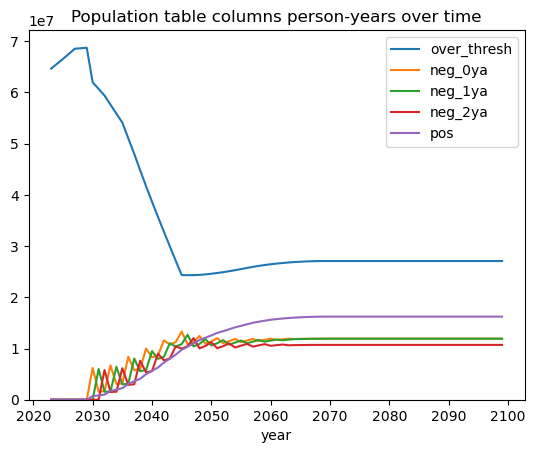

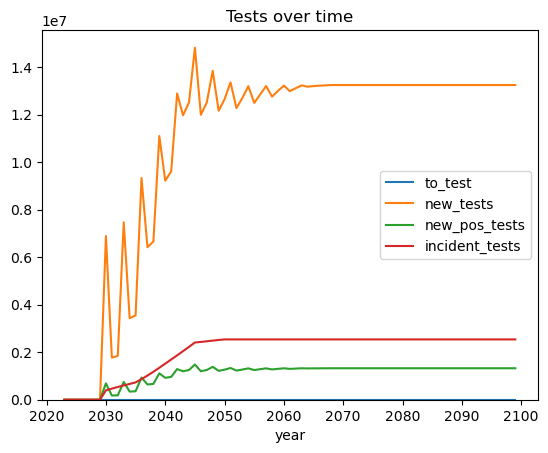

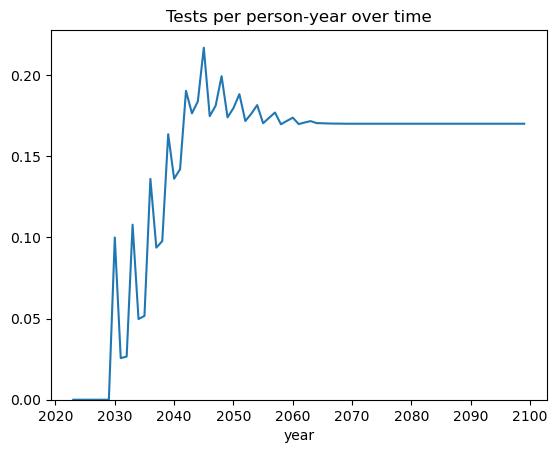

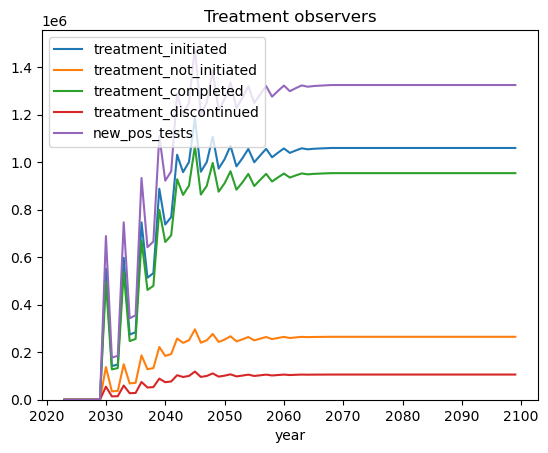

In [56]:
age_groups.plot()
plt.ylim(bottom=0)
plt.title("Age group person-years over time")
plt.show()
age_groups.sum(axis=1).plot()
plt.ylim(bottom=0)
plt.title("Total person-years over time")
plt.show()
pop_components.plot()
plt.ylim(bottom=0)
plt.title("Population components person-years over time")
plt.show()
columns.plot()
plt.ylim(bottom=0)
plt.title("Population table columns person-years over time")
plt.show()
tests.plot()
plt.ylim(bottom=0)
plt.title("Tests over time")
plt.show()
(tests["new_tests"] / age_groups.sum(axis=1)).plot()
plt.ylim(bottom=0)
plt.title("Tests per person-year over time")
plt.show()
treatment.plot()
plt.ylim(bottom=0)
plt.title("Treatment observers")
plt.show()

In [60]:
# Calculate total results...
# number of BBBM tests conducted,
display(
    f"Total BBBM tests conducted from {SIM_START} to {SIM_END}: {non_age_observers['new_tests'].sum()}"
)
# number of BBBM tests that are false positives,
display(
    f"Total false positive BBBM tests from {SIM_START} to {SIM_END}: {non_age_observers['new_pos_tests'].sum()}"
)
# number of unnecessary treatments.
display(
    f"Total uncessecary treatments initiated from {SIM_START} to {SIM_END}: {non_age_observers['treatment_initiated'].sum()}"
)

'Total BBBM tests conducted from 2023 to 2100: 837520291.1718061'

'Total false positive BBBM tests from 2023 to 2100: 83752029.11718062'

'Total uncessecary treatments initiated from 2023 to 2100: 67001623.29374451'